# Libraries

In [21]:
import os
import time
import random
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import (LinearRegression, ElasticNet, ElasticNetCV, SGDRegressor)
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, LSTM, GRU, TimeDistributed,LayerNormalization
                                     , MultiHeadAttention, GlobalAveragePooling1D, Bidirectional, Layer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, Loss
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.models import Sequential as KerasSequential
from keras.layers import Dense as KerasDense, Dropout as KerasDropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam as KerasAdam
from keras.callbacks import EarlyStopping as KerasEarlyStopping, ReduceLROnPlateau as KerasReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.losses import Huber as KerasHuber
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)



In [55]:
from scipy.stats import pearsonr
import pandas as pd
import time
import numpy as np
from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Flatten,
    LSTM,
    GRU,
    LayerNormalization,
    MultiHeadAttention,
    Layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, Loss
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
)
import os
import random
import itertools
import warnings
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import yfinance as yf
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from xgboost import XGBRegressor
import tensorflow as tf


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


# Import data

In [18]:
df_GSPC = pd.read_excel("df_GSPC.xlsx", index_col="Date")
df_NDX = pd.read_excel("df_NDX.xlsx", index_col="Date")
df_DJI = pd.read_excel("df_DJI.xlsx", index_col="Date")
df_FTSE = pd.read_excel("df_FTSE.xlsx", index_col="Date")
df_GDAXI = pd.read_excel("df_GDAXI.xlsx", index_col="Date")

# Other functions

In [19]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2


In [20]:
def generate_signal(row, treshhold):
    if abs(row['Prediction'] / row['Close_yesterday'] -1) <= treshhold:
        return 'no_signal'
    elif row['Prediction'] > row['Close_yesterday']:
        return 'buy'
    elif row['Prediction'] < row['Close_yesterday']:
        return 'sell'
    else:
        return 'no_signal'

def calculate_trades(df, initial_capital, upper_level_loss=1.025, lower_level_loss=0.975, upper_level_win=1.2, lower_level_win=0.8):
    capital = initial_capital
    current_position = None
    current_shares = 0
    buy_price = 0
    taxes = 0
    taxes_rate = 0.001

    for i in range(len(df)):
        row = df.iloc[i]
        signal = row['signal']
        open_price = row['Open']
        high_price = row['High']
        low_price = row['Low']
        close_price = row['Close']

        transaction = 'Not_traded'

        if current_position is None:
            if signal == 'buy':
                current_shares = capital // open_price
                taxes = taxes_rate * current_shares * open_price
                df.at[row.name, 'taxes'] = taxes
                capital = capital - taxes
                buy_price = open_price
                current_position = 'buy'
                transaction = 'Open_Buy'
            elif signal == 'sell':
                current_shares = capital // open_price
                taxes = taxes_rate * current_shares * open_price
                df.at[row.name, 'taxes'] = taxes
                capital = capital - taxes
                buy_price = open_price
                current_position = 'sell'
                transaction = 'Open_Short'
        elif current_position == 'buy':
            if signal == 'sell':
                pnl = (open_price - buy_price) * current_shares
                df.at[row.name, 'PnL'] = pnl
                capital += pnl
                taxes = taxes_rate * current_shares * open_price + capital // open_price * open_price * taxes_rate
                df.at[row.name, 'taxes'] = taxes
                capital = capital - taxes
                transaction = 'Close_Buy_Signal/Open_Short'
                current_shares = capital // open_price
                buy_price = open_price
                current_position = 'sell'
            elif high_price >= buy_price * upper_level_win:
                pnl = (max(buy_price * upper_level_win,open_price) - buy_price) * current_shares
                df.at[row.name, 'PnL'] = pnl
                taxes = taxes_rate * current_shares * max(buy_price * upper_level_win,open_price)
                df.at[row.name, 'taxes'] = taxes
                capital += pnl
                capital = capital - taxes
                transaction = 'Close_Buy_reached_High'
                current_position = None
            elif low_price <= buy_price * lower_level_loss:
                pnl = (min(buy_price * lower_level_loss,open_price) - buy_price) * current_shares
                df.at[row.name, 'PnL'] = pnl
                capital += pnl
                taxes = taxes_rate * current_shares * min(buy_price * lower_level_loss,open_price)
                capital = capital - taxes
                df.at[row.name, 'taxes'] = taxes
                transaction = 'Close_Buy_reached_Low'
                current_position = None
            else:
                df.at[row.name, 'PnL'] = 0
                transaction = 'Held_position'

        elif current_position == 'sell':
            if signal == 'buy':
                pnl = (buy_price - open_price) * current_shares
                df.at[row.name, 'PnL'] = pnl
                taxes = taxes_rate * current_shares * open_price + capital // open_price * open_price * taxes_rate
                df.at[row.name, 'taxes'] = taxes
                capital += pnl
                capital = capital - taxes
                transaction = 'Close_Short_Signal/Open_Buy'
                current_shares = capital // open_price
                buy_price = open_price
                current_position = 'buy'
            elif low_price <= buy_price * lower_level_win:
                pnl = (buy_price - min(buy_price * lower_level_win,open_price)) * current_shares
                capital += pnl
                df.at[row.name, 'PnL'] = pnl
                taxes = taxes_rate * current_shares * min(buy_price * lower_level_win,open_price)
                df.at[row.name, 'taxes'] = taxes
                capital = capital - taxes
                transaction = 'Close_Short_reached_Low'
                current_position = None
            elif high_price >= buy_price * upper_level_loss:
                pnl = (buy_price - max(buy_price * upper_level_loss,open_price)) * current_shares
                capital += pnl
                df.at[row.name, 'PnL'] = pnl
                taxes = taxes_rate * current_shares * max(buy_price * upper_level_loss,open_price)
                df.at[row.name, 'taxes'] = taxes
                capital = capital - taxes
                transaction = 'Close_Short_reached_High'
                current_position = None
            else:
                df.at[row.name, 'PnL'] = 0
                transaction = 'Held_position'

        df.at[row.name, 'shares'] = current_shares
        df.at[row.name, 'capital'] = capital
        df.at[row.name, 'position'] = current_position
        df.at[row.name, 'transaction'] = transaction
        if current_position == 'buy':
            unrealized_capital = capital + (close_price - buy_price) * current_shares
        elif current_position == 'sell':
            unrealized_capital = capital + (buy_price - close_price) * current_shares
        else:
            unrealized_capital = capital

        df.at[row.name, 'unrealized_capital'] = unrealized_capital

    return df

def calculate_return_and_drawdown(df, initial_cash=100000, tax=0.01):

    buy_price = df.iloc[0]['Open']
    buy_price_with_tax = buy_price * (1 + tax)

    shares = int(initial_cash // buy_price_with_tax)
    invested_amount = shares * buy_price_with_tax

    leftover_cash = initial_cash - invested_amount

    value_low = df['Low'] * shares + leftover_cash
    cumulative_max = value_low.cummax()
    drawdowns = (value_low - cumulative_max) / cumulative_max
    max_drawdown = drawdowns.min()

    sell_price = df.iloc[-1]['Close']
    sell_price_after_tax = sell_price * (1 - tax)
    final_value = shares * sell_price_after_tax + leftover_cash

    total_return = (final_value - initial_cash) / initial_cash

    return total_return, max_drawdown

def financials(data, column_name, name, algorithm, treshhold,plotting = 0):

  df = data.copy()
  df.rename(columns={column_name: 'Prediction'}, inplace=True)

  mse_fin, mae_fin, r2_fin = calculate_metrics(df["Close"], df["Prediction"])

  df["Change"] = df["Close"] / df["Close_yesterday"] - 1
  df["pred_change"] = df["Prediction"] / df["Close_yesterday"] - 1
  df["direction_correct"] = np.where((df["Change"] * df["pred_change"]) >= 0,1,0).astype(int)
  directional_accuracy = df["direction_correct"].mean() * 100

  df['signal'] = df.apply(generate_signal, args=(treshhold,), axis=1)
  df = df.dropna()
  initial_capital = 100000.0
  df['shares'] = 0.0
  df['PnL'] = 0.0
  df['taxes'] = 0.0
  df['capital'] = initial_capital
  df['unrealized_capital'] = initial_capital
  df['position'] = None
  df['transaction'] = 'None'


  financials = calculate_trades(df, initial_capital, upper_level_loss=1.05, lower_level_loss=0.95, upper_level_win=1.1, lower_level_win=0.9)
  financials.index = pd.to_datetime(financials.index)
  cumulative_max = financials['unrealized_capital'].cummax()
  drawdown = (financials['unrealized_capital'] - cumulative_max) / cumulative_max
  max_drawdown = drawdown.min()

  total_return = (financials['unrealized_capital'].iloc[-1] - initial_capital) / initial_capital

  trading_days = len(financials)
  annualized_return = (1 + total_return) ** (252 / trading_days) - 1

  calmar_ratio = annualized_return / abs(max_drawdown)

  trades_qy = (financials["taxes"] != 0).sum()

  total_return_threshold, max_drawdown_threshold = calculate_return_and_drawdown(financials, initial_cash=initial_capital, tax=0.001)

  metrics = {
      'Name': name,
      'Algorithm' : algorithm,
      'MSE': mse_fin,
      'MAE': mae_fin,
      'R_squered': r2_fin,
      'Max Drawdown': [f'{max_drawdown * 100:.2f}%'],
      'Total Return': [total_return],
      'Annualized Return': annualized_return * 100,
      'Calmar Ratio': [calmar_ratio],
      'Max Drawdown Threshold': [f'{max_drawdown_threshold * 100:.2f}%'],
      'Total Return Threshold': [f'{total_return_threshold * 100:.2f}%'],
      'trades': [trades_qy],
      'directional_accuracy': [directional_accuracy]
  }

  metrics_df = pd.DataFrame(metrics)

  if plotting == 1:
    plt.figure(figsize=(8, 4))
    plt.plot(financials.index, financials['capital'], label='Capital')
    plt.plot(financials.index, financials['unrealized_capital'], label='Unrealized Capital', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Capital')
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.savefig("financials.pdf")
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(financials.index, financials["Close"], label='True Price')
    plt.plot(financials.index, financials["Prediction"], label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(rf"{algorithm} - Final Test Set Predictions - {name}")
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.xticks(rotation=45)

  return metrics_df, financials

In [21]:
def prepare_data(df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps):

  df.index = pd.to_datetime(df.index)

  df['Close_yesterday'] = df['Close'].shift(1)

  df["Change"] = df["Close"] / df["Close_yesterday"] - 1

  df = df.dropna(subset=['Change'])

  start_date_train = pd.to_datetime(start_date_train)
  end_date_train = pd.to_datetime(end_date_train)
  start_date_test = pd.to_datetime(start_date_test)
  end_date_test = pd.to_datetime(end_date_test)

  data_train = df[(df.index <= end_date_train) & (df.index >= start_date_train)].copy()

  start_idx = df.index.get_indexer([start_date_test], method='bfill')[0]
  start_with_padding_idx = max(0, start_idx - time_steps)
  start_with_padding_date = df.index[start_with_padding_idx]

  data_test = df[(df.index >= start_with_padding_date) & (df.index <= end_date_test)].copy()

  data_final_test = df[(df.index >= start_date_test) & (df.index <= end_date_test)].copy()

  scaled_data = data_train[['Change']].values
  scaled_data_fin = data_test[['Change']].values

  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(scaled_data)
  scaled_data_fin = scaler.transform(scaled_data_fin)

  X_train, y_train = create_dataset(scaled_data, time_steps)

  X_test, y_test_fin = create_dataset(scaled_data_fin, time_steps)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return data_final_test, X_train, y_train, X_test, scaler

# Models

## LSTM

In [22]:
def LSTM_Model(df, name, start_date_train = '2000-01-01', end_date_train = '2010-01-01', start_date_test = '2021-01-01',
               end_date_test = '2023-01-01', units_layer1=128, units_layer2=64, dropout_rate=0.1,
               learning_rate=1e-4, epochs=4, batch_size=16, time_steps=5, plotting = 0):

  start_time = time.time()

  data_test_final, X_train, y_train, X_test_fin, scaler = prepare_data(df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps)

  model = Sequential()
  model.add(Input(shape=(time_steps, 1)))
  model.add(LSTM(units_layer1, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(units_layer2))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
            validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

  y_pred_lstm_fin = model.predict(X_test_fin)

  y_pred_lstm_fin = scaler.inverse_transform(y_pred_lstm_fin.reshape(-1, 1))

  data_test_final['pred_change'] = y_pred_lstm_fin[:, 0]

  data_test_final["direction_correct"] = np.where((data_test_final["Change"] * data_test_final["pred_change"]) >= 0,1,0).astype(int)
  directional_accuracy = data_test_final["direction_correct"].mean() * 100

  data_test_final["Prediction"] = (data_test_final["pred_change"] + 1) * (data_test_final["Close_yesterday"])

  mse_fin, mae_fin, r2_fin = calculate_metrics(data_test_final["Close"], data_test_final["Prediction"])

  end_time = time.time()
  training_time = end_time - start_time

  results_dict = {
      'name': name,
      'start_date_train' : start_date_train,
      'end_date_train' : end_date_train,
      'start_date_test' : start_date_test,
      'end_date_test' : end_date_test,
      'time_steps' : time_steps,
      'units_layer1': units_layer1,
      'units_layer2': units_layer2,
      'dropout_rate': dropout_rate,
      'learning_rate': learning_rate,
      'epochs': epochs,
      'batch_size': batch_size,
      'mse': mse_fin,
      'mae': mae_fin,
      'r2': r2_fin,
      'directional_accuracy': directional_accuracy,
      'training_time_sec': training_time
      }

  if plotting == 1:
      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Close"], label='True Price')
      plt.plot(data_test_final.index, data_test_final["Prediction"], label='Predicted Price')
      plt.xlabel('Time')
      plt.ylabel('Stock Price')
      plt.title(rf"LSTM - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)
      plt.show()

      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Change"], label='True Change')
      plt.plot(data_test_final.index, data_test_final["pred_change"], label='Predicted Change')
      plt.xlabel('Time')
      plt.ylabel('Stock Price Change')
      plt.title(rf"LSTM - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)
      plt.show()

  return data_test_final, results_dict

## GRU

In [23]:
def GRU_Model(df, name, start_date_train = '2000-01-01', end_date_train = '2010-01-01', start_date_test = '2021-01-01',
               end_date_test = '2023-01-01', units_layer1=128, units_layer2=64, dropout_rate=0.1,
               learning_rate=1e-4, epochs=4, batch_size=16, time_steps=5, plotting = 0):

  start_time = time.time()

  data_test_final, X_train, y_train, X_test_fin, scaler = prepare_data(df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps)

  model = Sequential()
  model.add(Input(shape=(time_steps, 1)))
  model.add(GRU(units_layer1, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(GRU(units_layer2))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
            validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

  y_pred_lstm_fin = model.predict(X_test_fin)

  y_pred_lstm_fin = scaler.inverse_transform(y_pred_lstm_fin.reshape(-1, 1))

  data_test_final['pred_change'] = y_pred_lstm_fin[:, 0]

  data_test_final["direction_correct"] = np.where((data_test_final["Change"] * data_test_final["pred_change"]) >= 0,1,0).astype(int)
  directional_accuracy = data_test_final["direction_correct"].mean() * 100

  data_test_final["Prediction"] = (data_test_final["pred_change"] + 1) * (data_test_final["Close_yesterday"])

  mse_fin, mae_fin, r2_fin = calculate_metrics(data_test_final["Close"], data_test_final["Prediction"])

  end_time = time.time()
  training_time = end_time - start_time

  results_dict = {
      'name': name,
      'start_date_train' : start_date_train,
      'end_date_train' : end_date_train,
      'start_date_test' : start_date_test,
      'end_date_test' : end_date_test,
      'time_steps' : time_steps,
      'units_layer1': units_layer1,
      'units_layer2': units_layer2,
      'dropout_rate': dropout_rate,
      'learning_rate': learning_rate,
      'epochs': epochs,
      'batch_size': batch_size,
      'mse': mse_fin,
      'mae': mae_fin,
      'r2': r2_fin,
      'directional_accuracy': directional_accuracy,
      'training_time_sec': training_time
      }

  if plotting == 1:
      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Close"], label='True Price')
      plt.plot(data_test_final.index, data_test_final["Prediction"], label='Predicted Price')
      plt.xlabel('Time')
      plt.ylabel('Stock Price')
      plt.title(rf"GRU - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)
      plt.show()

      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Change"], label='True Change')
      plt.plot(data_test_final.index, data_test_final["pred_change"], label='Predicted Change')
      plt.xlabel('Time')
      plt.ylabel('Stock Price Change')
      plt.title(rf"GRU - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)

      plt.show()

  return data_test_final, results_dict

## DMLP

In [24]:
def DMLP_Model(df, name, start_date_train = '2000-01-01', end_date_train = '2010-01-01', start_date_test = '2021-01-01',
               end_date_test = '2023-01-01', units_layer1=128, units_layer2=64, dropout_rate=0.1,
               learning_rate=1e-4, epochs=4, batch_size=16, time_steps=5, plotting = 0):

  start_time = time.time()

  data_test_final, X_train, y_train, X_test_fin, scaler = prepare_data(df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps)

  model = Sequential()
  model.add(Input(shape=(time_steps, 1)))
  model.add(Flatten())
  model.add(Dense(units_layer1, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units_layer2, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  model.fit(X_train, y_train,
      epochs=epochs, batch_size=batch_size,
      validation_split=0.2, verbose=1,
      callbacks=[early_stopping, reduce_lr])

  y_pred_dmlp_fin = model.predict(X_test_fin)
  y_pred_dmlp_fin = scaler.inverse_transform(y_pred_dmlp_fin.reshape(-1, 1))

  data_test_final['pred_change'] = y_pred_dmlp_fin[:, 0]

  data_test_final["direction_correct"] = np.where((data_test_final["Change"] * data_test_final["pred_change"]) >= 0, 1, 0).astype(int)
  directional_accuracy = data_test_final["direction_correct"].mean() * 100

  data_test_final["Prediction"] = (data_test_final["pred_change"] + 1) * (data_test_final["Close_yesterday"])

  mse_fin, mae_fin, r2_fin = calculate_metrics(data_test_final["Close"], data_test_final["Prediction"])

  end_time = time.time()
  training_time = end_time - start_time

  results_dict = {
      'name': name,
      'start_date_train' : start_date_train,
      'end_date_train' : end_date_train,
      'start_date_test' : start_date_test,
      'end_date_test' : end_date_test,
      'time_steps' : time_steps,
      'units_layer1': units_layer1,
      'units_layer2': units_layer2,
      'dropout_rate': dropout_rate,
      'learning_rate': learning_rate,
      'epochs': epochs,
      'batch_size': batch_size,
      'mse': mse_fin,
      'mae': mae_fin,
      'r2': r2_fin,
      'directional_accuracy': directional_accuracy,
      'training_time_sec': training_time
  }

  if plotting == 1:
      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Close"], label='True Price')
      plt.plot(data_test_final.index, data_test_final["Prediction"], label='Predicted Price')
      plt.xlabel('Time')
      plt.ylabel('Stock Price')
      plt.title(rf"DMLP - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)
      plt.show()

      plt.figure(figsize=(14, 5))
      plt.plot(data_test_final.index, data_test_final["Change"], label='True Change')
      plt.plot(data_test_final.index, data_test_final["pred_change"], label='Predicted Change')
      plt.xlabel('Time')
      plt.ylabel('Stock Price Change')
      plt.title(rf"DMLP - Final Test Set Predictions - {name}")
      plt.legend()
      plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
      plt.xticks(rotation=45)
      plt.show()

  return data_test_final, results_dict


## XGBoost

In [25]:
def XGB_Model(df, name, start_date_train='2000-01-01', end_date_train='2010-01-01',
              start_date_test='2021-01-01', end_date_test='2023-01-01',
              n_estimators=300, max_depth=4, learning_rate=0.05,
              subsample=0.9, colsample_bytree=0.9,
              time_steps=5, plotting=0, random_state=42):

    start_time = time.time()

    data_test_final, X_train, y_train, X_test_fin, scaler = prepare_data(df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps)

    X_train_flat = X_train.reshape((X_train.shape[0], -1))
    X_test_flat  = X_test_fin.reshape((X_test_fin.shape[0], -1))

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=-1,
        verbosity=0)

    model.fit(X_train_flat, y_train)

    y_pred_xgb_scaled = model.predict(X_test_flat).reshape(-1, 1)
    y_pred_xgb_fin = scaler.inverse_transform(y_pred_xgb_scaled)

    data_test_final['pred_change'] = y_pred_xgb_fin[:, 0]

    data_test_final["direction_correct"] = np.where((data_test_final["Change"] * data_test_final["pred_change"]) >= 0, 1, 0).astype(int)
    directional_accuracy = data_test_final["direction_correct"].mean() * 100

    data_test_final["Prediction"] = (data_test_final["pred_change"] + 1) * (data_test_final["Close_yesterday"])

    mse_fin, mae_fin, r2_fin = calculate_metrics(data_test_final["Close"], data_test_final["Prediction"])

    end_time = time.time()
    training_time = end_time - start_time

    results_dict = {
        'name': name,
        'start_date_train': start_date_train,
        'end_date_train': end_date_train,
        'start_date_test': start_date_test,
        'end_date_test': end_date_test,
        'time_steps': time_steps,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'random_state': random_state,
        'mse': mse_fin,
        'mae': mae_fin,
        'r2': r2_fin,
        'directional_accuracy': directional_accuracy,
        'training_time_sec': training_time
    }

    if plotting == 1:
        plt.figure(figsize=(14, 5))
        plt.plot(data_test_final.index, data_test_final["Close"], label='True Price')
        plt.plot(data_test_final.index, data_test_final["Prediction"], label='Predicted Price')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.title(rf"XGBoost - Final Test Set Predictions - {name}")
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.show()

        plt.figure(figsize=(14, 5))
        plt.plot(data_test_final.index, data_test_final["Change"], label='True Change')
        plt.plot(data_test_final.index, data_test_final["pred_change"], label='Predicted Change')
        plt.xlabel('Time')
        plt.ylabel('Stock Price Change')
        plt.title(rf"XGBoost - Final Test Set Predictions - {name}")
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.show()

    return data_test_final, results_dict


## Transformers

In [26]:
def Transformer_Model(
    df, name,
    start_date_train='2000-01-01', end_date_train='2010-01-01',
    start_date_test='2021-01-01', end_date_test='2023-01-01',
    d_model=64, num_heads=4, ff_dim=128, num_layers=2,
    dropout_rate=0.1, learning_rate=1e-4,
    epochs=10, batch_size=32, time_steps=20, plotting=0):

    class PositionalEmbedding(Layer):
        def __init__(self, maxlen, d_model, **kwargs):
            super().__init__(**kwargs)
            self.maxlen = maxlen
            self.d_model = d_model
            self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=d_model)

        def call(self, x):
            seq_len = tf.shape(x)[1]
            positions = tf.range(start=0, limit=seq_len, delta=1)
            pos_encoding = self.pos_emb(positions)
            return x + pos_encoding

    class TransformerEncoderBlock(Layer):
        def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
            super().__init__(**kwargs)
            self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
            self.ffn = tf.keras.Sequential([
                Dense(ff_dim, activation='relu'),
                Dropout(dropout_rate),
                Dense(d_model),
            ])
            self.norm1 = LayerNormalization(epsilon=1e-6)
            self.norm2 = LayerNormalization(epsilon=1e-6)
            self.dropout = Dropout(dropout_rate)

        def call(self, x, training=False):
            attn_output = self.mha(x, x, training=training)
            attn_output = self.dropout(attn_output, training=training)
            out1 = self.norm1(x + attn_output)

            ffn_output = self.ffn(out1, training=training)
            ffn_output = self.dropout(ffn_output, training=training)
            out2 = self.norm2(out1 + ffn_output)
            return out2

    start_time = time.time()

    data_test_final, X_train, y_train, X_test_fin, scaler = prepare_data(
        df, start_date_train, end_date_train, start_date_test, end_date_test, time_steps
    )
    assert len(X_train.shape) == 3 and X_train.shape[-1] == 1


    inp = Input(shape=(time_steps, 1))
    x = Dense(d_model)(inp)
    x = PositionalEmbedding(maxlen=time_steps, d_model=d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoderBlock(d_model, num_heads, ff_dim, dropout_rate)(x)
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.2, verbose=1,
        callbacks=[early_stopping, reduce_lr])


    y_pred_scaled = model.predict(X_test_fin)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    data_test_final['pred_change'] = y_pred[:, 0]

    data_test_final["direction_correct"] = np.where((data_test_final["Change"] * data_test_final["pred_change"]) >= 0, 1, 0).astype(int)
    directional_accuracy = data_test_final["direction_correct"].mean() * 100

    data_test_final["Prediction"] = (data_test_final["pred_change"] + 1) * (data_test_final["Close_yesterday"])

    mse_fin, mae_fin, r2_fin = calculate_metrics(data_test_final["Close"], data_test_final["Prediction"])

    end_time = time.time()
    training_time = end_time - start_time

    results_dict = {
        'name': name,
        'start_date_train': start_date_train,
        'end_date_train': end_date_train,
        'start_date_test': start_date_test,
        'end_date_test': end_date_test,
        'time_steps': time_steps,
        'd_model': d_model,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'num_layers': num_layers,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': batch_size,
        'mse': mse_fin,
        'mae': mae_fin,
        'r2': r2_fin,
        'directional_accuracy': directional_accuracy,
        'training_time_sec': training_time
    }

    if plotting == 1:
        plt.figure(figsize=(14, 5))
        plt.plot(data_test_final.index, data_test_final["Close"], label='True Price')
        plt.plot(data_test_final.index, data_test_final["Prediction"], label='Predicted Price')
        plt.xlabel('Time'); plt.ylabel('Stock Price')
        plt.title(rf"Transformer - Final Test Set Predictions - {name}")
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.show()

        plt.figure(figsize=(14, 5))
        plt.plot(data_test_final.index, data_test_final["Change"], label='True Change')
        plt.plot(data_test_final.index, data_test_final["pred_change"], label='Predicted Change')
        plt.xlabel('Time'); plt.ylabel('Stock Price Change')
        plt.title(rf"Transformer - Final Test Set Predictions - {name}")
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.show()

    return data_test_final, results_dict


# Train best and prepare for ensemble

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.3420 - mae: 0.6604 - val_loss: 0.2999 - val_mae: 0.5810 - learning_rate: 0.0010
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.3345 - mae: 0.6492 - val_loss: 0.2983 - val_mae: 0.5780 - learning_rate: 0.0010
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.3745 - mae: 0.6967 - val_loss: 0.2969 - val_mae: 0.5756 - learning_rate: 0.0010
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.3519 - mae: 0.6739 - val_loss: 0.2962 - val_mae: 0.5748 - learning_rate: 0.0010
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.3578 - mae: 0.6737 - val_loss: 0.2971 - val_mae: 0.5765 - learning_rate: 0.0010
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.3467 - mae: 0.6601 - val_loss: 0.3882 - val_mae: 0.7200 - learning_rate: 0.0010
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.3392 - mae: 0.6495 - val_loss: 0.3866 - val_mae: 0.

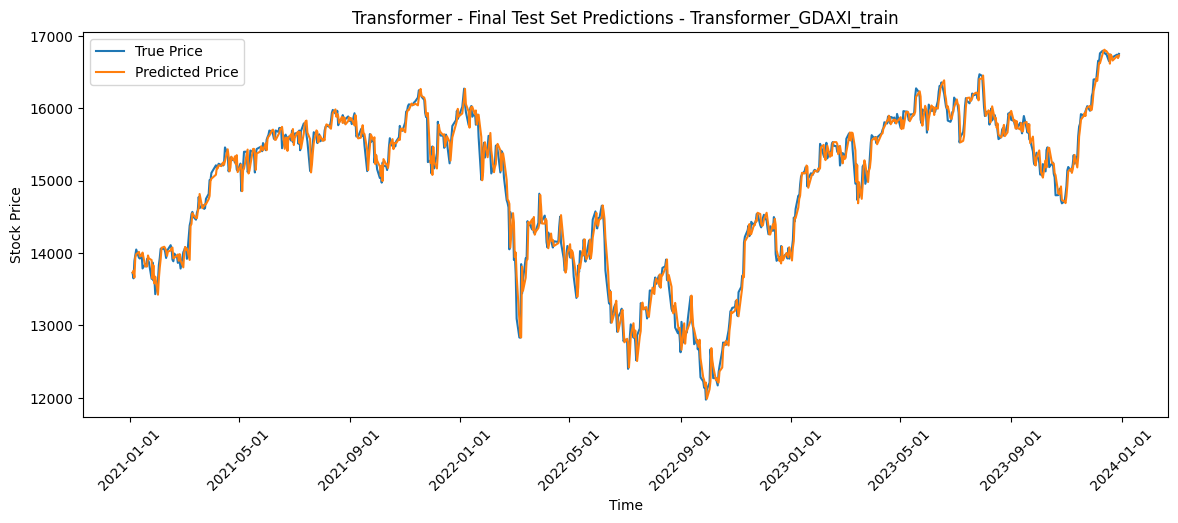

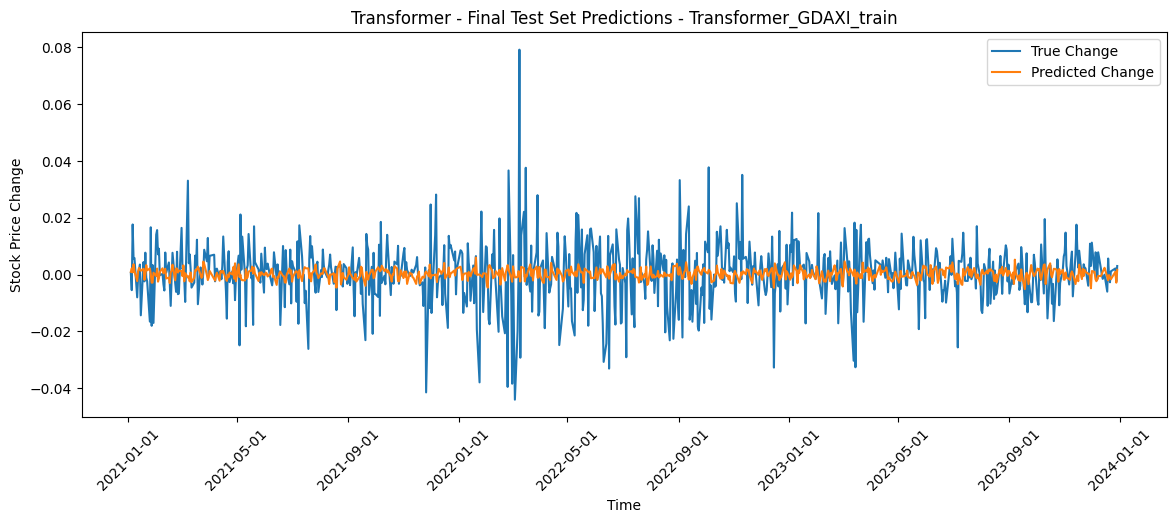

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - loss: 1.0259 - mae: 1.4531 - val_loss: 0.3613 - val_mae: 0.7096 - learning_rate: 1.0000e-04
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 0.8497 - mae: 1.2681 - val_loss: 0.3466 - val_mae: 0.6850 - learning_rate: 1.0000e-04
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.8140 - mae: 1.2287 - val_loss: 0.3226 - val_mae: 0.6450 - learning_rate: 1.0000e-04
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.7449 - mae: 1.1494 - val_loss: 0.3106 - val_mae: 0.6260 - learning_rate: 1.0000e-04
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.7104 - mae: 1.1120 - val_loss: 0.3329 - val_mae: 0.6586 - learning_rate: 1.0000e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


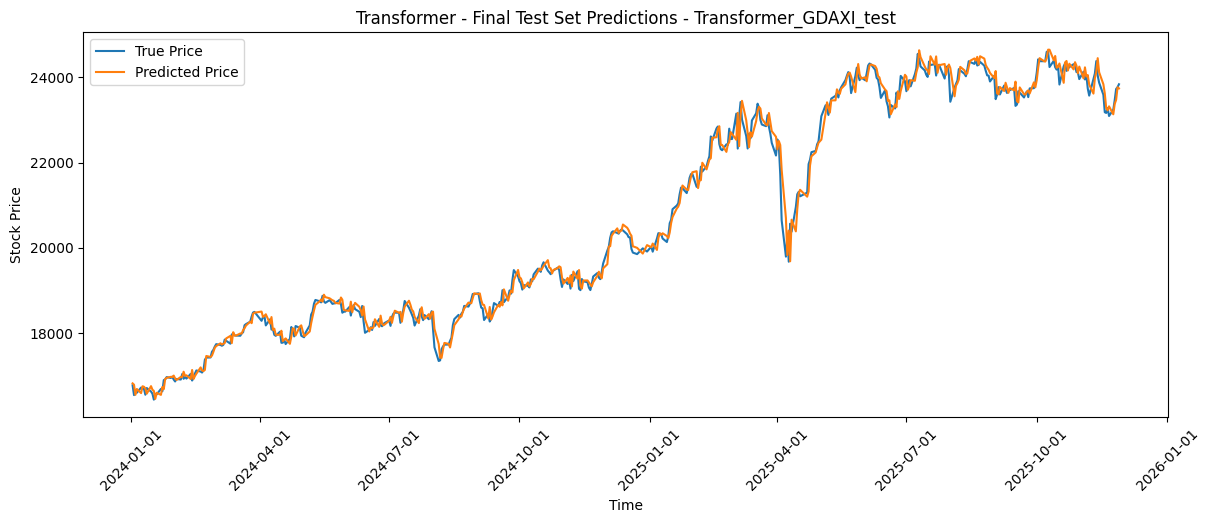

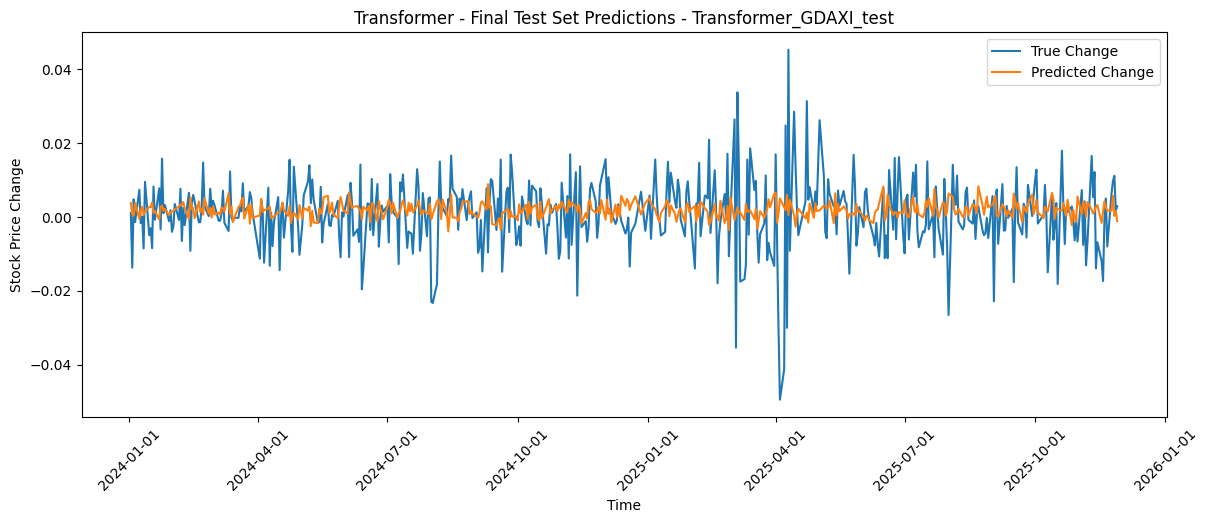

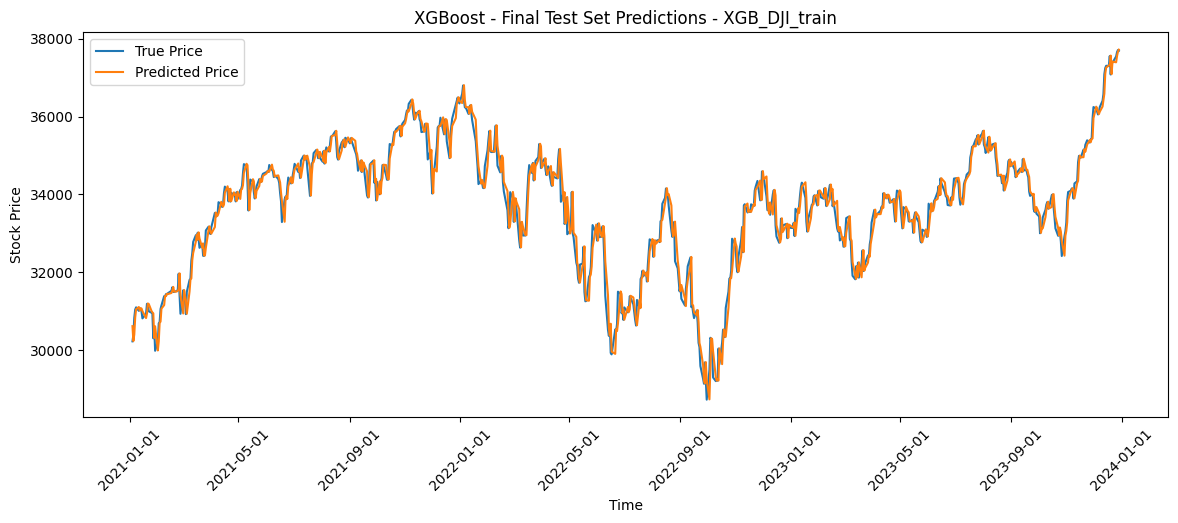

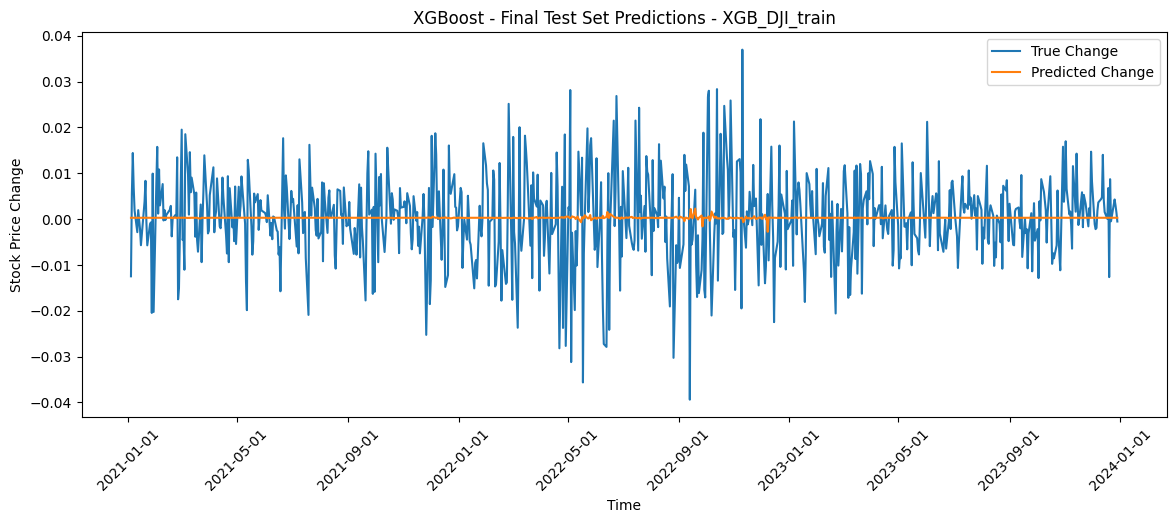

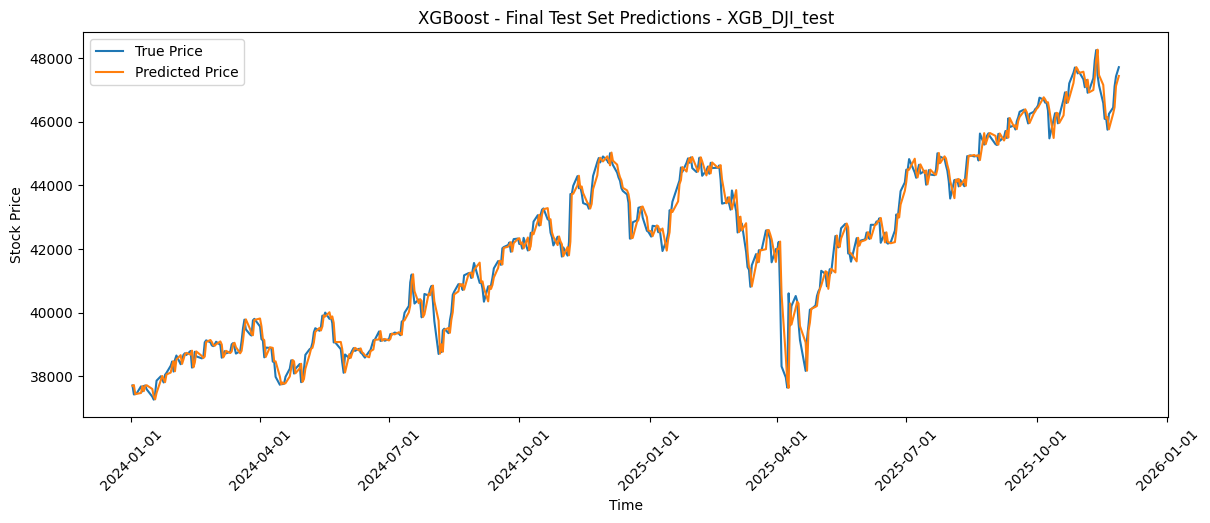

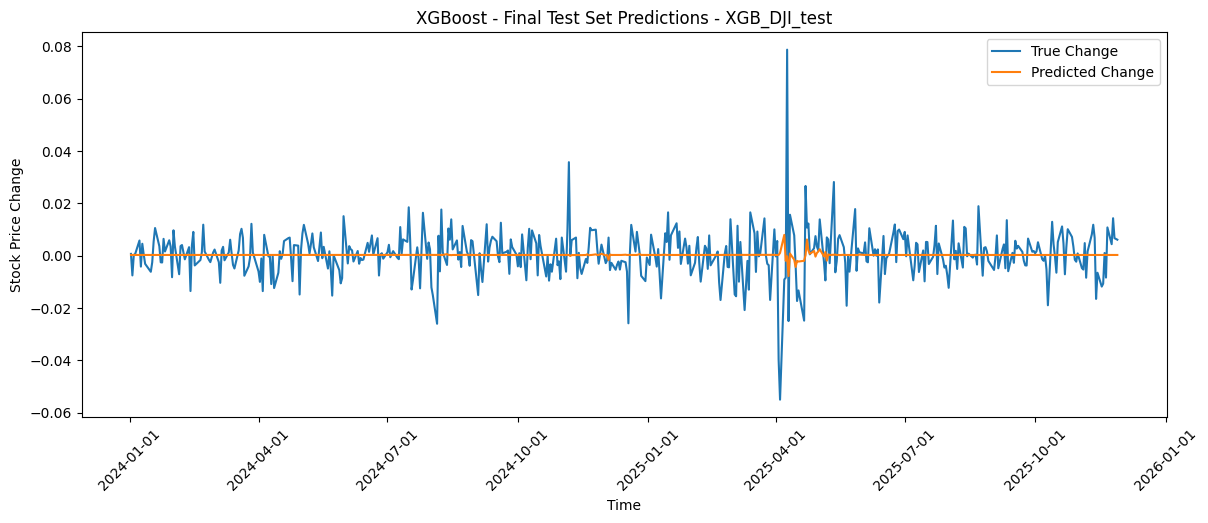

NameError: name 'LSTM_FTSE_train' is not defined

In [27]:
LSTM_GSPC_train, results_dict = LSTM_Model(df_GSPC, "LSTM_GSPC_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_GSPC_test, results_dict = LSTM_Model(df_GSPC, "LSTM_GSPC_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_FTSE_train, results_dict = LSTM_Model(df_FTSE, "LSTM_FTSE_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_FTSE_test, results_dict = LSTM_Model(df_FTSE, "LSTM_FTSE_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_GDAXI_train, results_dict = LSTM_Model(df_GDAXI, "LSTM_GDAXI_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_GDAXI_test, results_dict = LSTM_Model(df_GDAXI, "LSTM_GDAXI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_DJI_train, results_dict = LSTM_Model(df_DJI, "LSTM_DJI_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_DJI_test, results_dict = LSTM_Model(df_DJI, "LSTM_DJI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_NDX_train, results_dict = LSTM_Model(df_NDX, "LSTM_NDX_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

LSTM_NDX_test, results_dict = LSTM_Model(df_NDX, "LSTM_NDX_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_GSPC_train, results_dict = GRU_Model(df_GSPC, "GRU_GSPC_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_GSPC_test, results_dict = GRU_Model(df_GSPC, "GRU_GSPC_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_FTSE_train, results_dict = GRU_Model(df_FTSE, "GRU_FTSE_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_FTSE_test, results_dict = GRU_Model(df_FTSE, "GRU_FTSE_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = v, plotting = 0)

GRU_NDX_train, results_dict = GRU_Model(df_NDX, "GRU_NDX_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_NDX_test, results_dict = GRU_Model(df_NDX, "GRU_NDX_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_GDAXI_train, results_dict = GRU_Model(df_GDAXI, "GRU_GDAXI_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_GDAXI_test, results_dict = GRU_Model(df_GDAXI, "GRU_GDAXI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_DJI_train, results_dict = GRU_Model(df_DJI, "GRU_DJI_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

GRU_DJI_test, results_dict = GRU_Model(df_DJI, "GRU_DJI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_DJI_train, results_dict = DMLP_Model(df_DJI, "DMLP_DJI_train",'2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_DJI_test, results_dict = DMLP_Model(df_DJI, "DMLP_DJI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_GSPC_train, results_dict = DMLP_Model(df_GSPC, "DMLP_GSPC_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_GSPC_test, results_dict = DMLP_Model(df_GSPC, "DMLP_GSPC_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_FTSE_train, results_dict = DMLP_Model(df_FTSE, "DMLP_FTSE_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_FTSE_test, results_dict = DMLP_Model(df_FTSE, "DMLP_FTSE_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_NDX_train, results_dict = DMLP_Model(df_NDX, "DMLP_NDX_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_NDX_test, results_dict = DMLP_Model(df_NDX, "DMLP_NDX_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_GDAXI_train, results_dict = DMLP_Model(df_GDAXI, "DMLP_GDAXI_train", '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)

DMLP_GDAXI_test, results_dict = DMLP_Model(df_GDAXI, "DMLP_GDAXI_test", '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                           units_layer1 = 256, units_layer2 = 128,
                                           dropout_rate = 0.3, learning_rate = 0.001, epochs = 500,
                                           batch_size = 64, time_steps = 30, plotting = 0)


Transformer_GDAXI_train, results_dict = Transformer_Model(df_GDAXI, "Transformer_GDAXI_train",
                                                          '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 500, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_GDAXI_test, results_dict = Transformer_Model(df_GDAXI, "Transformer_GDAXI_test",
                                                          '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 300, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_GSPC_train, results_dict = Transformer_Model(df_GSPC, "Transformer_GSPC_train",
                                                          '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 500, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_GSPC_test, results_dict = Transformer_Model(df_GSPC, "Transformer_GSPC_test",
                                                          '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 300, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_FTSE_train, results_dict = Transformer_Model(df_FTSE, "Transformer_FTSE_train",
                                                          '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 500, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_FTSE_test, results_dict = Transformer_Model(df_FTSE, "Transformer_FTSE_test",
                                                          '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 300, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_NDX_train, results_dict = Transformer_Model(df_NDX, "Transformer_NDX_train",
                                                          '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 500, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_NDX_test, results_dict = Transformer_Model(df_NDX, "Transformer_NDX_test",
                                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 300, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_DJI_train, results_dict = Transformer_Model(df_DJI, "Transformer_DJI_train",
                                                          '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 500, batch_size = 64,
                                                          time_steps = 30, plotting = 0)

Transformer_DJI_test, results_dict = Transformer_Model(df_DJI, "Transformer_DJI_test",
                                                          '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                                          d_model = 64, num_heads = 4, ff_dim = 256, num_layers = 3,
                                                          dropout_rate = 0.3, learning_rate = 0.0001,
                                                          epochs = 300, batch_size = 64,
                                                          time_steps = 30, plotting = 0)


XGB_DJI_train, results_dict  = XGB_Model(df_DJI, "XGB_DJI_train",
                                         '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_DJI_test, results_dict  = XGB_Model(df_DJI, "XGB_DJI_test",
                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_GSPC_train, results_dict  = XGB_Model(df_GSPC, "XGB_GSPC_train",
                                         '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_GSPC_test, results_dict  = XGB_Model(df_GSPC, "XGB_GSPC_test",
                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_FTSE_train, results_dict  = XGB_Model(df_FTSE, "XGB_FTSE_train",
                                         '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_FTSE_test, results_dict  = XGB_Model(df_FTSE, "XGB_FTSE_test",
                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_NDX_train, results_dict  = XGB_Model(df_NDX, "XGB_NDX_train",
                                         '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_NDX_test, results_dict  = XGB_Model(df_NDX, "XGB_NDX_test",
                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_GDAXI_train, results_dict  = XGB_Model(df_GDAXI, "XGB_GDAXI_train",
                                         '2000-01-03', '2021-01-01', '2021-01-01', '2024-01-01',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

XGB_GDAXI_test, results_dict  = XGB_Model(df_GDAXI, "XGB_GDAXI_test",
                                         '2000-01-03', '2024-01-01', '2024-01-01', '2025-11-30',
                                         n_estimators = 300, max_depth = 3, learning_rate = 0.005,
                                         subsample = 0.7 , colsample_bytree = 1,
                                         time_steps = 30, plotting = 1, random_state = 7)

LSTM_GSPC_train = LSTM_GSPC_train.rename(columns={'Prediction': 'LSTM_GSPC'})
LSTM_GSPC_test = LSTM_GSPC_test.rename(columns={'Prediction': 'LSTM_GSPC'})

LSTM_FTSE_train = LSTM_FTSE_train.rename(columns={'Prediction': 'LSTM_FTSE'})
LSTM_FTSE_test = LSTM_FTSE_test.rename(columns={'Prediction': 'LSTM_FTSE'})

LSTM_GDAXI_train = LSTM_GDAXI_train.rename(columns={'Prediction': 'LSTM_GDAXI'})
LSTM_GDAXI_test = LSTM_GDAXI_test.rename(columns={'Prediction': 'LSTM_GDAXI'})

LSTM_DJI_train = LSTM_DJI_train.rename(columns={'Prediction': 'LSTM_DJI'})
LSTM_DJI_test = LSTM_DJI_test.rename(columns={'Prediction': 'LSTM_DJI'})

LSTM_NDX_train = LSTM_NDX_train.rename(columns={'Prediction': 'LSTM_NDX'})
LSTM_NDX_test = LSTM_NDX_test.rename(columns={'Prediction': 'LSTM_NDX'})

GRU_GSPC_train = GRU_GSPC_train.rename(columns={'Prediction': 'GRU_GSPC'})
GRU_GSPC_test = GRU_GSPC_test.rename(columns={'Prediction': 'GRU_GSPC'})

GRU_FTSE_train = GRU_FTSE_train.rename(columns={'Prediction': 'GRU_FTSE'})
GRU_FTSE_test = GRU_FTSE_test.rename(columns={'Prediction': 'GRU_FTSE'})

GRU_NDX_train = GRU_NDX_train.rename(columns={'Prediction': 'GRU_NDX'})
GRU_NDX_test = GRU_NDX_test.rename(columns={'Prediction': 'GRU_NDX'})

GRU_GDAXI_train = GRU_GDAXI_train.rename(columns={'Prediction': 'GRU_GDAXI'})
GRU_GDAXI_test = GRU_GDAXI_test.rename(columns={'Prediction': 'GRU_GDAXI'})

GRU_DJI_train = GRU_DJI_train.rename(columns={'Prediction': 'GRU_DJI'})
GRU_DJI_test = GRU_DJI_test.rename(columns={'Prediction': 'GRU_DJI'})

DMLP_DJI_train = DMLP_DJI_train.rename(columns={'Prediction': 'DMLP_DJI'})
DMLP_DJI_test = DMLP_DJI_test.rename(columns={'Prediction': 'DMLP_DJI'})

DMLP_GSPC_train = DMLP_GSPC_train.rename(columns={'Prediction': 'DMLP_GSPC'})
DMLP_GSPC_test = DMLP_GSPC_test.rename(columns={'Prediction': 'DMLP_GSPC'})

DMLP_FTSE_train = DMLP_FTSE_train.rename(columns={'Prediction': 'DMLP_FTSE'})
DMLP_FTSE_test = DMLP_FTSE_test.rename(columns={'Prediction': 'DMLP_FTSE'})

DMLP_NDX_train = DMLP_NDX_train.rename(columns={'Prediction': 'DMLP_NDX'})
DMLP_NDX_test = DMLP_NDX_test.rename(columns={'Prediction': 'DMLP_NDX'})

DMLP_GDAXI_train = DMLP_GDAXI_train.rename(columns={'Prediction': 'DMLP_GDAXI'})
DMLP_GDAXI_test = DMLP_GDAXI_test.rename(columns={'Prediction': 'DMLP_GDAXI'})

Transformer_GDAXI_train = Transformer_GDAXI_train.rename(columns={'Prediction': 'Transformer_GDAXI'})
Transformer_GDAXI_test = Transformer_GDAXI_test.rename(columns={'Prediction': 'Transformer_GDAXI'})

Transformer_GSPC_train = Transformer_GSPC_train.rename(columns={'Prediction': 'Transformer_GSPC'})
Transformer_GSPC_test = Transformer_GSPC_test.rename(columns={'Prediction': 'Transformer_GSPC'})

Transformer_FTSE_train = Transformer_FTSE_train.rename(columns={'Prediction': 'Transformer_FTSE'})
Transformer_FTSE_test = Transformer_FTSE_test.rename(columns={'Prediction': 'Transformer_FTSE'})

Transformer_NDX_train = Transformer_NDX_train.rename(columns={'Prediction': 'Transformer_NDX'})
Transformer_NDX_test = Transformer_NDX_test.rename(columns={'Prediction': 'Transformer_NDX'})

Transformer_DJI_train = Transformer_DJI_train.rename(columns={'Prediction': 'Transformer_DJI'})
Transformer_DJI_test = Transformer_DJI_test.rename(columns={'Prediction': 'Transformer_DJI'})

XGB_DJI_train = XGB_DJI_train.rename(columns={'Prediction': 'XGB_DJI'})
XGB_DJI_test = XGB_DJI_test.rename(columns={'Prediction': 'XGB_DJI'})

XGB_GSPC_train = XGB_GSPC_train.rename(columns={'Prediction': 'XGB_GSPC'})
XGB_GSPC_test = XGB_GSPC_test.rename(columns={'Prediction': 'XGB_GSPC'})

XGB_FTSE_train = XGB_FTSE_train.rename(columns={'Prediction': 'XGB_FTSE'})
XGB_FTSE_test = XGB_FTSE_test.rename(columns={'Prediction': 'XGB_FTSE'})

XGB_NDX_train = XGB_NDX_train.rename(columns={'Prediction': 'XGB_NDX'})
XGB_NDX_test = XGB_NDX_test.rename(columns={'Prediction': 'XGB_NDX'})

XGB_GDAXI_train = XGB_GDAXI_train.rename(columns={'Prediction': 'XGB_GDAXI'})
XGB_GDAXI_test = XGB_GDAXI_test.rename(columns={'Prediction': 'XGB_GDAXI'})

# -------------------------
# GSPC
# -------------------------
GSPC_train_preds = (
    LSTM_GSPC_train[['LSTM_GSPC']]
        .join(GRU_GSPC_train[['GRU_GSPC']], how='inner')
        .join(DMLP_GSPC_train[['DMLP_GSPC']], how='inner')
        .join(Transformer_GSPC_train[['Transformer_GSPC']], how='inner')
        .join(XGB_GSPC_train[['XGB_GSPC']], how='inner')
)

GSPC_test_preds = (
    LSTM_GSPC_test[['LSTM_GSPC']]
        .join(GRU_GSPC_test[['GRU_GSPC']], how='inner')
        .join(DMLP_GSPC_test[['DMLP_GSPC']], how='inner')
        .join(Transformer_GSPC_test[['Transformer_GSPC']], how='inner')
        .join(XGB_GSPC_test[['XGB_GSPC']], how='inner')
)

# -------------------------
# FTSE
# -------------------------
FTSE_train_preds = (
    LSTM_FTSE_train[['LSTM_FTSE']]
        .join(GRU_FTSE_train[['GRU_FTSE']], how='inner')
        .join(DMLP_FTSE_train[['DMLP_FTSE']], how='inner')
        .join(Transformer_FTSE_train[['Transformer_FTSE']], how='inner')
        .join(XGB_FTSE_train[['XGB_FTSE']], how='inner')
)

FTSE_test_preds = (
    LSTM_FTSE_test[['LSTM_FTSE']]
        .join(GRU_FTSE_test[['GRU_FTSE']], how='inner')
        .join(DMLP_FTSE_test[['DMLP_FTSE']], how='inner')
        .join(Transformer_FTSE_test[['Transformer_FTSE']], how='inner')
        .join(XGB_FTSE_test[['XGB_FTSE']], how='inner')
)

# -------------------------
# GDAXI
# -------------------------
GDAXI_train_preds = (
    LSTM_GDAXI_train[['LSTM_GDAXI']]
        .join(GRU_GDAXI_train[['GRU_GDAXI']], how='inner')
        .join(DMLP_GDAXI_train[['DMLP_GDAXI']], how='inner')
        .join(Transformer_GDAXI_train[['Transformer_GDAXI']], how='inner')
        .join(XGB_GDAXI_train[['XGB_GDAXI']], how='inner')
)

GDAXI_test_preds = (
    LSTM_GDAXI_test[['LSTM_GDAXI']]
        .join(GRU_GDAXI_test[['GRU_GDAXI']], how='inner')
        .join(DMLP_GDAXI_test[['DMLP_GDAXI']], how='inner')
        .join(Transformer_GDAXI_test[['Transformer_GDAXI']], how='inner')
        .join(XGB_GDAXI_test[['XGB_GDAXI']], how='inner')
)

# -------------------------
# DJI
# -------------------------
DJI_train_preds = (
    LSTM_DJI_train[['LSTM_DJI']]
        .join(GRU_DJI_train[['GRU_DJI']], how='inner')
        .join(DMLP_DJI_train[['DMLP_DJI']], how='inner')
        .join(Transformer_DJI_train[['Transformer_DJI']], how='inner')
        .join(XGB_DJI_train[['XGB_DJI']], how='inner')
)

DJI_test_preds = (
    LSTM_DJI_test[['LSTM_DJI']]
        .join(GRU_DJI_test[['GRU_DJI']], how='inner')
        .join(DMLP_DJI_test[['DMLP_DJI']], how='inner')
        .join(Transformer_DJI_test[['Transformer_DJI']], how='inner')
        .join(XGB_DJI_test[['XGB_DJI']], how='inner')
)

# -------------------------
# NDX
# -------------------------
NDX_train_preds = (
    LSTM_NDX_train[['LSTM_NDX']]
        .join(GRU_NDX_train[['GRU_NDX']], how='inner')
        .join(DMLP_NDX_train[['DMLP_NDX']], how='inner')
        .join(Transformer_NDX_train[['Transformer_NDX']], how='inner')
        .join(XGB_NDX_train[['XGB_NDX']], how='inner')
)

NDX_test_preds = (
    LSTM_NDX_test[['LSTM_NDX']]
        .join(GRU_NDX_test[['GRU_NDX']], how='inner')
        .join(DMLP_NDX_test[['DMLP_NDX']], how='inner')
        .join(Transformer_NDX_test[['Transformer_NDX']], how='inner')
        .join(XGB_NDX_test[['XGB_NDX']], how='inner')
)

# Saving (if needed)

In [ ]:
dfs_to_save = {
    "GSPC_train_preds": GSPC_train_preds,
    "GSPC_test_preds": GSPC_test_preds,
    "FTSE_train_preds": FTSE_train_preds,
    "FTSE_test_preds": FTSE_test_preds,
    "GDAXI_train_preds": GDAXI_train_preds,
    "GDAXI_test_preds": GDAXI_test_preds,
    "DJI_train_preds": DJI_train_preds,
    "DJI_test_preds": DJI_test_preds,
    "NDX_train_preds": NDX_train_preds,
    "NDX_test_preds": NDX_test_preds
}

for df_name, df_obj in dfs_to_save.items():
    file_path = os.path.join(f"{df_name}.xlsx")
    df_obj.to_excel(file_path, index=True)
    print(f"Saved: {file_path}")

Saved: GSPC_train_preds.xlsx
Saved: GSPC_test_preds.xlsx
Saved: FTSE_train_preds.xlsx
Saved: FTSE_test_preds.xlsx
Saved: GDAXI_train_preds.xlsx
Saved: GDAXI_test_preds.xlsx
Saved: DJI_train_preds.xlsx
Saved: DJI_test_preds.xlsx
Saved: NDX_train_preds.xlsx
Saved: NDX_test_preds.xlsx


# Read Data

In [40]:
df_names = [
    "GSPC_train_preds", "GSPC_test_preds",
    "FTSE_train_preds", "FTSE_test_preds",
    "GDAXI_train_preds", "GDAXI_test_preds",
    "DJI_train_preds", "DJI_test_preds",
    "NDX_train_preds", "NDX_test_preds"
]

dfs_loaded = {}

for df_name in df_names:
    file_path = os.path.join(f"{df_name}.xlsx")
    if os.path.exists(file_path):
        dfs_loaded[df_name] = pd.read_excel(file_path)
        print(f"Loaded: {file_path}")
    else:
        print(f"File not found: {file_path}")

for df_name, df_obj in dfs_loaded.items():
    globals()[df_name] = df_obj


Loaded: GSPC_train_preds.xlsx
Loaded: GSPC_test_preds.xlsx
Loaded: FTSE_train_preds.xlsx
Loaded: FTSE_test_preds.xlsx
Loaded: GDAXI_train_preds.xlsx
Loaded: GDAXI_test_preds.xlsx
Loaded: DJI_train_preds.xlsx
Loaded: DJI_test_preds.xlsx
Loaded: NDX_train_preds.xlsx
Loaded: NDX_test_preds.xlsx


# Prepare data for financial calculations

In [41]:
START, END = "2024-01-01", "2025-11-30"
tickers = ["GSPC", "FTSE", "GDAXI", "DJI", "NDX"]

for t in tickers:
    df = globals().get(f"df_{t}")
    preds = globals().get(f"{t}_test_preds")
    if df is None or preds is None:
        print(f"Skipping {t}: missing df_{t} or {t}_test_preds")
        continue

    df.index = pd.to_datetime(df.index)

    df['Close_yesterday'] = df['Close'].shift(1)
    df["Change"] = df["Close"] / df["Close_yesterday"] - 1

    df_cut = df.loc[START:END]

    preds["Date"] = pd.to_datetime(preds["Date"])
    preds = preds.set_index("Date")

    preds = preds.merge(df_cut[["Close", "Close_yesterday","Open","High","Low","Change"]], left_index=True, right_index=True, how="left")

    globals()[f"df_{t}_cut"] = df_cut
    globals()[f"{t}_test_preds"] = preds

In [42]:
START, END = "2021-01-01", "2024-01-01"
tickers = ["GSPC", "FTSE", "GDAXI", "DJI", "NDX"]

for t in tickers:
    df = globals().get(f"df_{t}")
    preds = globals().get(f"{t}_train_preds")
    if df is None or preds is None:
        print(f"Skipping {t}: missing df_{t} or {t}_train_preds")
        continue

    df.index = pd.to_datetime(df.index)
    df_cut = df.loc[START:END]

    preds["Date"] = pd.to_datetime(preds["Date"])
    preds = preds.set_index("Date")

    preds = preds.merge(df_cut[["Close", "Close_yesterday","Open","High","Low","Change"]], left_index=True, right_index=True, how="left")

    globals()[f"df_{t}_cut"] = df_cut
    globals()[f"{t}_train_preds"] = preds

# Ensemble and Financial Analysis

In [43]:
def add_change_columns(df):
    suffix = next(c.rsplit('_', 1)[1] for c in df.columns if '_' in c)
    cols = [c for c in df.columns if c.endswith(suffix)]
    for c in cols:
        model = c[:-(len(suffix)+1)]
        df[f"change_{model}_{suffix}"] = df[c].div(df[c].shift(1)).sub(1)
    return df

names = [
    "DJI_train_preds","DJI_test_preds",
    "FTSE_train_preds","FTSE_test_preds",
    "GDAXI_train_preds","GDAXI_test_preds",
    "GSPC_train_preds","GSPC_test_preds",
    "NDX_train_preds","NDX_test_preds",
]

for name in names:
    df = add_change_columns(locals()[name])

    if "Date" in df.columns and df.index.name != "Date":
        df = df.set_index("Date")

    df = df.iloc[1:]
    df = df.sort_index()

    locals()[name] = df


In [44]:
BASE_MODELS = ["LSTM", "GRU", "DMLP", "Transformer", "XGB"]
tickers = ["DJI", "FTSE", "GDAXI", "GSPC", "NDX"]

fee = 0.0001
plotting = 0

names = [
    "DJI_train_preds","DJI_test_preds",
    "FTSE_train_preds","FTSE_test_preds",
    "GDAXI_train_preds","GDAXI_test_preds",
    "GSPC_train_preds","GSPC_test_preds",
    "NDX_train_preds","NDX_test_preds",
]

dataframes_by_name = {name: globals()[name] for name in names}

results = []
results_b = []

def subsets_min_k(items, k: int):
    out = []
    for r in range(k, len(items)+1):
        for comb in itertools.combinations(items, r):
            out.append(tuple(sorted(comb)))
    return out

SUBSETS_2PLUS = subsets_min_k(BASE_MODELS, 2)

def run_name(ticker, model_type, subset):
    return f"{ticker}_{model_type}_{'_'.join(subset)}"

def price_cols(ticker, subset):
    return [f"{m}_{ticker}" for m in subset]

def change_cols(ticker, subset):
    return [f"change_{m}_{ticker}" for m in subset]

def add_financials(df_test, run_col, ticker, model_type):
    a, b = financials(df_test, run_col, ticker, model_type, fee, plotting=plotting)
    a = a.copy()
    a["ticker"] = ticker
    a["model"] = model_type
    a["run"] = run_col
    results.append(a)
    results_b.append(b)

def pred_close_from_change(df, pred_change):
    cy = pd.to_numeric(df["Close_yesterday"], errors="coerce").to_numpy(float)
    return cy * (1.0 + pred_change)

In [45]:
for ticker in tickers:
    tr = dataframes_by_name[f"{ticker}_train_preds"]
    te = dataframes_by_name[f"{ticker}_test_preds"]

    for subset in SUBSETS_2PLUS:
        cols = price_cols(ticker, subset)

        avg_tr = tr[cols].apply(pd.to_numeric, errors="coerce").mean(axis=1)
        avg_te = te[cols].apply(pd.to_numeric, errors="coerce").mean(axis=1)

        colname = run_name(ticker, "AVG", subset)

        if colname not in tr.columns: tr[colname] = avg_tr
        if colname not in te.columns: te[colname] = avg_te

        add_financials(te, colname, ticker, "AVG")

print("AVG done.")


AVG done.


In [46]:
for ticker in tickers:
    te = dataframes_by_name[f"{ticker}_test_preds"]

    for m in BASE_MODELS:
        colname = f"{m}_{ticker}"   # existing column
        add_financials(te, colname, ticker, m)

print("Base singles done.")


Base singles done.


In [47]:
model = Pipeline([
    ("scaler", StandardScaler()),
     ("lr", LinearRegression())])

for ticker in tickers:
    tr = dataframes_by_name[f"{ticker}_train_preds"]
    te = dataframes_by_name[f"{ticker}_test_preds"]

    y = pd.to_numeric(tr["Change"], errors="coerce").to_numpy(float)

    for subset in SUBSETS_2PLUS:
        cols = change_cols(ticker, subset)

        Xtr = tr[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
        Xte = te[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)

        model.fit(Xtr, y)

        pred_te_change = model.predict(Xte)
        pred_te_close  = pred_close_from_change(te, pred_te_change)

        colname = run_name(ticker, "LR", subset)
        if colname not in te.columns: te[colname] = pred_te_close

        add_financials(te, colname, ticker, "LR")

print("LR done.")


LR done.


In [48]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0, random_state=0))
])

for ticker in tickers:
    tr = dataframes_by_name[f"{ticker}_train_preds"]
    te = dataframes_by_name[f"{ticker}_test_preds"]

    y = pd.to_numeric(tr["Change"], errors="coerce").to_numpy(float)

    for subset in SUBSETS_2PLUS:
        cols = change_cols(ticker, subset)

        Xtr = tr[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
        Xte = te[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)

        model.fit(Xtr, y)

        pred_te_close = pred_close_from_change(te, model.predict(Xte))

        colname = run_name(ticker, "PR", subset)
        if colname not in te.columns: te[colname] = pred_te_close

        add_financials(te, colname, ticker, "PR")

print("PR done.")


PR done.


In [49]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("en", ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=20000, random_state=0))
])

for ticker in tickers:
    tr = dataframes_by_name[f"{ticker}_train_preds"]
    te = dataframes_by_name[f"{ticker}_test_preds"]

    y = pd.to_numeric(tr["Change"], errors="coerce").to_numpy(float)

    for subset in SUBSETS_2PLUS:
        cols = change_cols(ticker, subset)

        Xtr = tr[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
        Xte = te[cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)

        model.fit(Xtr, y)

        pred_te_close = pred_close_from_change(te, model.predict(Xte))

        colname = run_name(ticker, "EN", subset)
        if colname not in te.columns: te[colname] = pred_te_close

        add_financials(te, colname, ticker, "EN")

final_results_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

## Saving (if needed)

In [ ]:
final_results_df.to_excel("final_results_df_new.xlsx", index=True)

## Saving final results

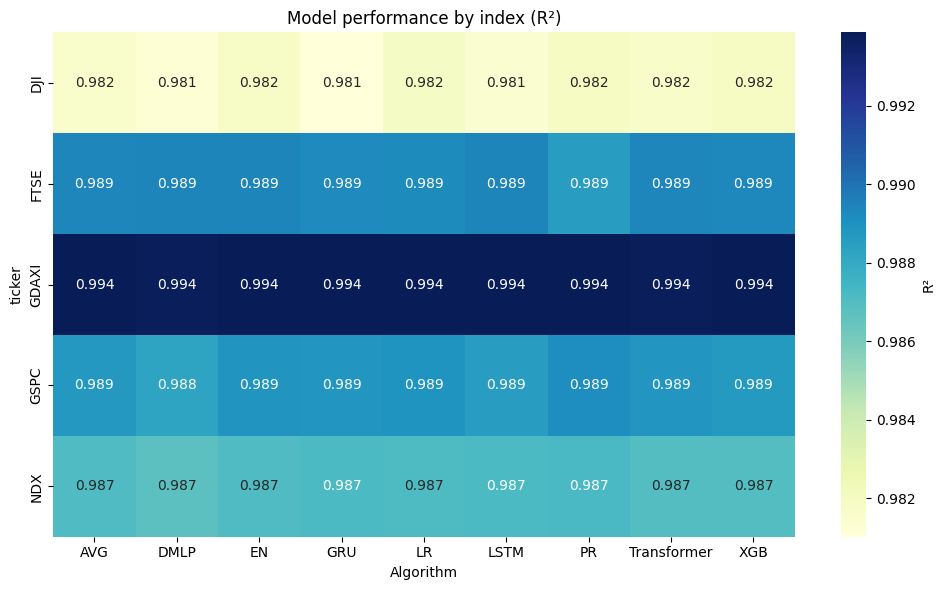

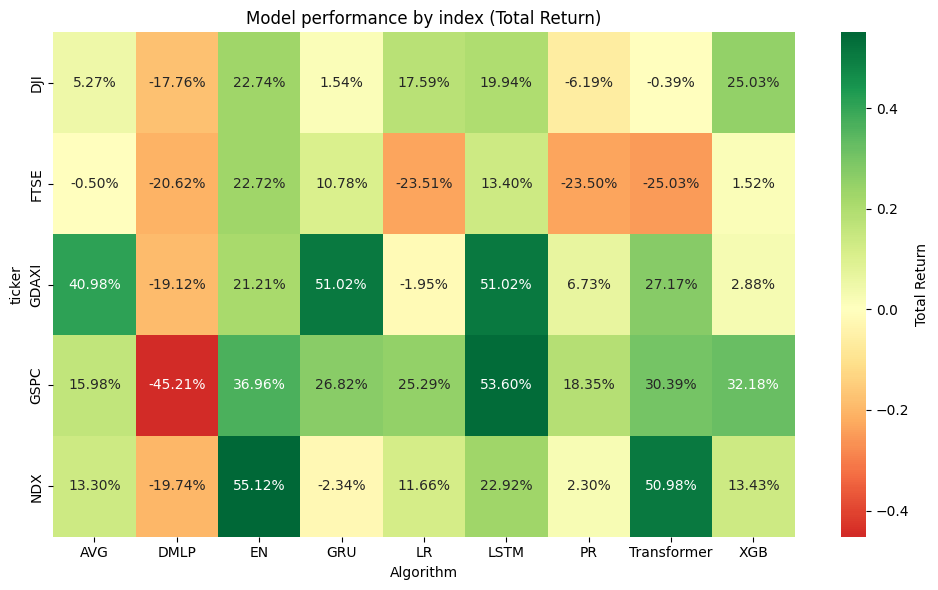

In [51]:
final_results_df['R_squered'] = final_results_df['R_squered'].astype(str).str.replace(",", ".").astype(float)
final_results_df['Total Return'] = final_results_df['Total Return'].astype(str).str.replace(",", ".").astype(float)

pivot_r2 = final_results_df.pivot_table(index="ticker", columns="Algorithm", values="R_squered", aggfunc="mean")
pivot_return = final_results_df.pivot_table(index="ticker", columns="Algorithm", values="Total Return", aggfunc="mean")

# Plot heatmap for R^2
plt.figure(figsize=(10,6))
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'R²'})
plt.title("Model performance by index (R²)")
plt.tight_layout()
plt.savefig("heatmap_r2.pdf")
plt.savefig("heatmap_r2.png", dpi=300)
plt.show()
plt.close()

# Plot heatmap for Total Return
plt.figure(figsize=(10,6))
sns.heatmap(pivot_return, annot=True, fmt=".2%", cmap="RdYlGn", center=0, cbar_kws={'label': 'Total Return'})
plt.title("Model performance by index (Total Return)")
plt.tight_layout()
plt.savefig("heatmap_return.pdf")
plt.savefig("heatmap_return.png", dpi=300)
plt.show()
plt.close()

## Loading final results

In [56]:
df = pd.read_excel("final_results_df.xlsx", sheet_name="Sheet1")

## scatter plot of R2 vs. Total Return

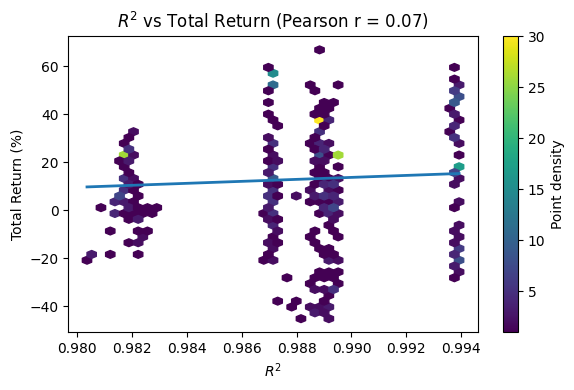

In [60]:
x = df["R_squered"].values
y = df["Total Return"].values * 100

# Pearson correlation
r, _ = pearsonr(x, y)

fig, ax = plt.subplots(figsize=(6, 4))

hb = ax.hexbin(
    x, y,
    gridsize=40,
    mincnt=1,
    cmap="viridis"
)

# Regression line
m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 100)
ax.plot(xx, m * xx + b, color="tab:blue", linewidth=2)

ax.set_xlabel(r"$R^2$")
ax.set_ylabel("Total Return (%)")
ax.set_title(rf"$R^2$ vs Total Return (Pearson r = {r:.2f})")

cb = fig.colorbar(hb, ax=ax)
cb.set_label("Point density")

fig.tight_layout()
fig.savefig("r2_vs_total_return.pdf")
plt.show()
plt.close(fig)


## heatmap for R^2 and heatmap for Total Return

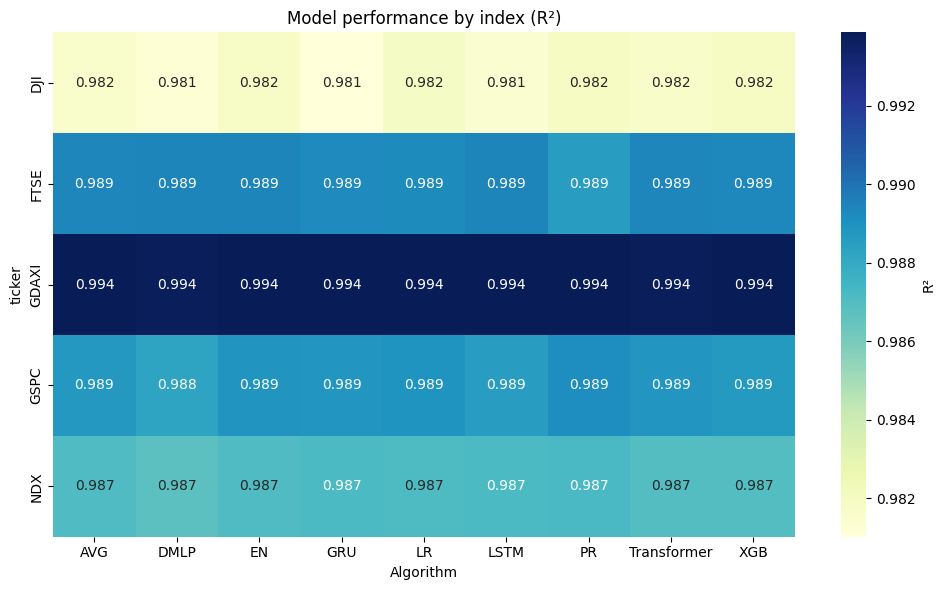

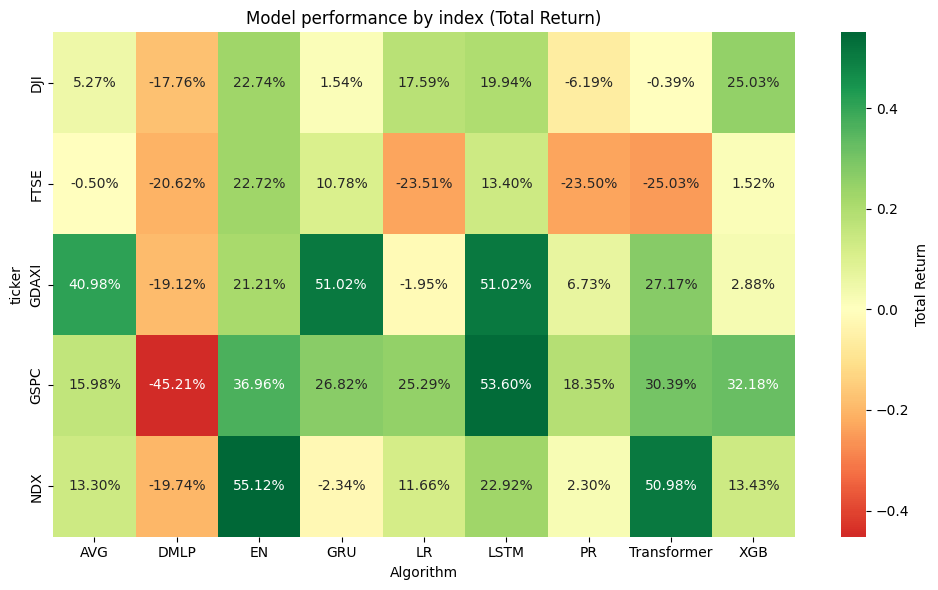

In [59]:

df['R_squered'] = df['R_squered'].astype(str).str.replace(",", ".").astype(float)
df['Total Return'] = df['Total Return'].astype(str).str.replace(",", ".").astype(float)

pivot_r2 = df.pivot_table(index="ticker", columns="Algorithm", values="R_squered", aggfunc="mean")
pivot_return = df.pivot_table(index="ticker", columns="Algorithm", values="Total Return", aggfunc="mean")

# Plot heatmap for R^2
plt.figure(figsize=(10,6))
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'R²'})
plt.title("Model performance by index (R²)")
plt.tight_layout()
# plt.savefig("heatmap_r2.pdf")
# plt.savefig("heatmap_r2.png", dpi=300)
plt.show()
plt.close()

# Plot heatmap for Total Return
plt.figure(figsize=(10,6))
sns.heatmap(pivot_return, annot=True, fmt=".2%", cmap="RdYlGn", center=0, cbar_kws={'label': 'Total Return'})
plt.title("Model performance by index (Total Return)")
plt.tight_layout()
# plt.savefig("heatmap_return.pdf")
# plt.savefig("heatmap_return.png", dpi=300)
plt.show()
plt.close()